# Adobe GenSolve R2

Team TLE eliminators:
- Aniruddh jain(*)
- Nikhil Tiwari

In [125]:
# import required libraries
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from sklearn.linear_model import LinearRegression

In [126]:
# read csv
def read_csv(csv_path):
    np_path_XYs=np.genfromtxt(csv_path,delimiter=',')
    path_XYs=[]
    for i in np.unique(np_path_XYs[:,0]):
        npXYs=np_path_XYs[np_path_XYs[:,0]==i][:,1:]
        XYs=[]
        for j in np.unique(npXYs[:,0]):
            XY=npXYs[npXYs[:,0]==j][:,1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

# plot image
def plot_polylines(paths_XYs, save_path=None):
    fig, ax = plt.subplots(tight_layout=True, figsize=(4, 4))
    for i, XYs in enumerate(paths_XYs):
        for XY in XYs:
            ax.plot(XY[:, 0], XY[:, 1], linewidth=2, label=f'Polyline {i}')
    ax.set_aspect("equal")
    ax.axis('off')

    if save_path:
        plt.savefig(save_path, format='jpg')

    plt.show()

## Open Curve

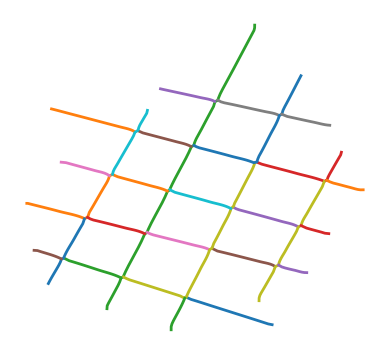

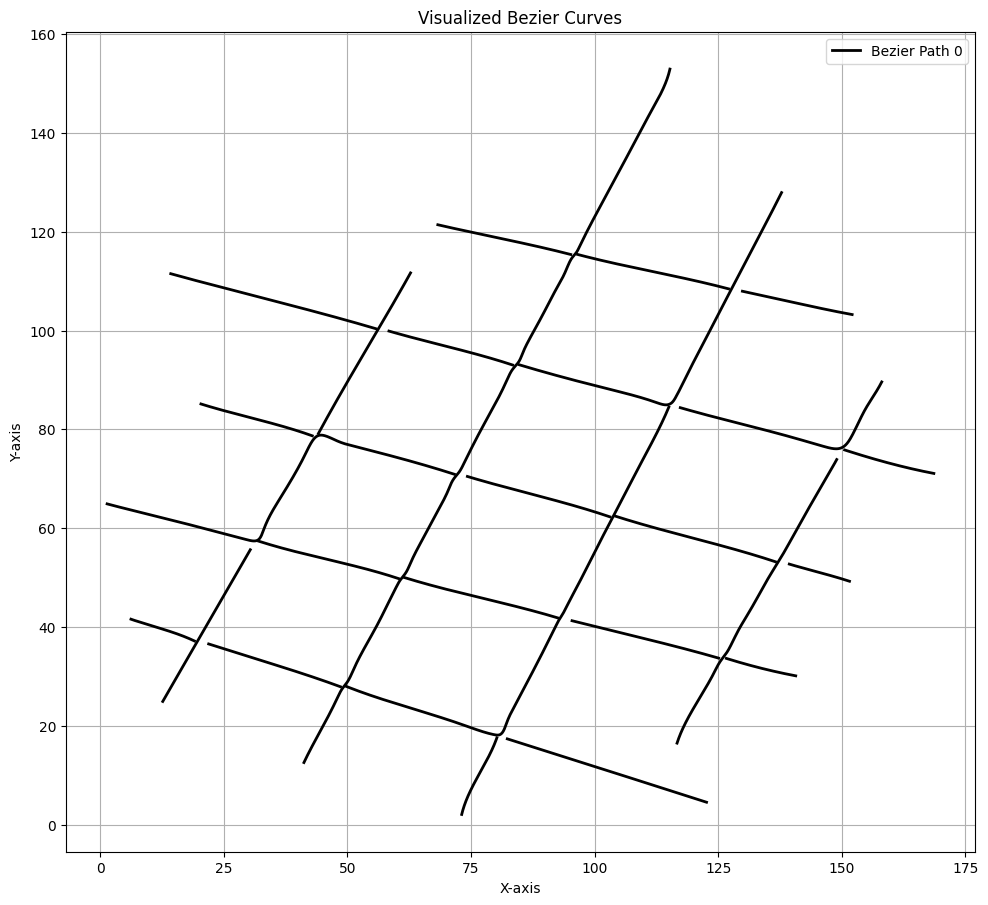

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

# Function to modify control points for smooth curves
def calc_control_pts(pts):
    # Make sure the first and last segments are linear
    if len(pts) > 2:
        pts[0] = 2 * pts[1] - pts[2]
        pts[-1] = 2 * pts[-2] - pts[-3]
    return pts

# Function to create a Bezier curve
def create_bezier_curve(pts, smoothness=0.8):
    pts = calc_control_pts(pts)
    tck, u = splprep([pts[:, 0], pts[:, 1]], s=smoothness, k=3)
    curve_u = np.linspace(0, 1.0, 2000)
    curve_pts = splev(curve_u, tck)
    return curve_pts

# Function to plot Bezier curves from paths
def visualize_bezier_curves(segments_XYs):
    fig, ax = plt.subplots(tight_layout=True, figsize=(10, 10))

    for idx, path_segments in enumerate(segments_XYs):
        for segment in path_segments:
            bezier_pts = create_bezier_curve(segment)
            ax.plot(bezier_pts[0], bezier_pts[1], linewidth=2, color='black', label=f'Bezier Path {idx}' if idx == 0 else "")

    # Improve plot clarity
    ax.set_aspect("equal")
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('Visualized Bezier Curves')
    ax.grid(True)
    plt.legend()
    plt.show()

# Example usage
csv_file = "frag2.csv"
paths_segments = read_csv(csv_file)
plot_polylines(paths_segments)
visualize_bezier_curves(paths_segments)

## Isolated Shapes


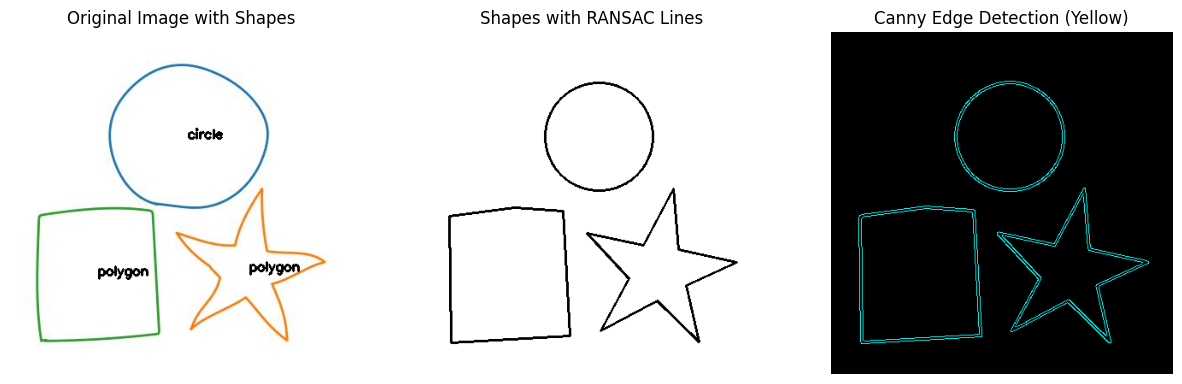

In [120]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor

def get_shape_name(approx):
    """Determine the shape based on the number of vertices."""
    if len(approx) == 2:
        return "line"
    elif len(approx) == 3:
        return "triangle"
    elif len(approx) == 4:
        (x, y, w, h) = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h
        if 0.95 <= aspect_ratio <= 1.05:
            return "square"
        else:
            return "rectangle"
    elif len(approx) > 12:
        return "circle"
    else:
        return "polygon"

def fit_line_ransac(points):
    """Fit a line to the given points using RANSAC."""
    X = points[:, 0].reshape(-1, 1)
    y = points[:, 1]

    ransac = RANSACRegressor(residual_threshold=1.0)
    ransac.fit(X, y)

    slope = ransac.estimator_.coef_[0]
    intercept = ransac.estimator_.intercept_
    return slope, intercept

def draw_fitted_line(image, slope, intercept, color):
    """Draw a fitted line on the image."""
    height, width = image.shape[:2]
    y1 = int(intercept)
    y2 = int(slope * width + intercept)
    cv2.line(image, (0, y1), (width, y2), color, 2)

def draw_shape(image, shape_type, points):
    """Draw different shapes based on the type."""
    if shape_type == "line":
        pt1 = tuple(points[0][0])
        pt2 = tuple(points[1][0])
        cv2.line(image, pt1, pt2, 0, 2)
    elif shape_type == "rectangle":
        x, y, w, h = cv2.boundingRect(points)
        top_left = (x, y)
        bottom_right = (x + w, y + h)
        cv2.rectangle(image, top_left, bottom_right, 0, 2)
    elif shape_type == "circle":
        (x, y), radius = cv2.minEnclosingCircle(points)
        center = (int(x), int(y))
        radius = int(radius) - 30
        cv2.circle(image, center, radius, 0, 2)
    elif shape_type == "triangle":
        cv2.drawContours(image, [points], 0, 0, 2)
    elif shape_type == "ellipse":
        ellipse = cv2.fitEllipse(points)
        cv2.ellipse(image, ellipse, 0, 2)
    elif shape_type == "polygon":
        cv2.polylines(image, [points], isClosed=True, color=0, thickness=2)
    else:
        raise ValueError("Unsupported shape_type")

def main():
    # Load and preprocess image
    img = cv2.imread('isolated.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150)
    kernel = np.ones((4, 4), np.uint8)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an image for drawing shapes and curves
    shape_image = np.ones_like(img) * 255

    for cont in contours:
        epsilon = 0.01 * cv2.arcLength(cont, True)
        approx = cv2.approxPolyDP(cont, epsilon, True)
        shape_name = get_shape_name(approx)

        # Calculate moments for the center of the contour
        M = cv2.moments(cont)
        if M['m00'] != 0.0:
            x = int(M['m10'] / M['m00'])
            y = int(M['m01'] / M['m00'])
            cv2.putText(img, shape_name, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

        # Draw shapes based on their type
        if shape_name == 'line':
            points = np.array(approx[:, 0], dtype=np.float32)
            slope, intercept = fit_line_ransac(points)
            draw_fitted_line(shape_image, slope, intercept, 0)
        elif shape_name in ['rectangle', 'circle', 'polygon']:
            draw_shape(shape_image, shape_name, approx)

    # Convert shape_image to grayscale for Canny edge detection
    shape_gray = cv2.cvtColor(shape_image, cv2.COLOR_BGR2GRAY)

    # Apply Canny Edge Detection
    canny_edges = cv2.Canny(shape_gray, 50, 150)

    # Convert Canny edges to a 3-channel image and color them yellow
    edges_color = np.zeros_like(img)
    edges_color[canny_edges > 0] = [255, 255, 0]  # Yellow color

    # Plot all results
    plt.figure(figsize=(15, 10))

    # Original Image with Shapes and Text
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image with Shapes')
    plt.axis('off')

    # Image with RANSAC-Fitted Lines and Shapes
    plt.subplot(1, 3, 2)
    plt.imshow(cv2.cvtColor(shape_image, cv2.COLOR_BGR2RGB))
    plt.title('Shapes with RANSAC Lines')
    plt.axis('off')

    # Image with Canny Edge Detection
    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(edges_color, cv2.COLOR_BGR2RGB))
    plt.title('Canny Edge Detection (Yellow)')
    plt.axis('off')

    plt.show()

if __name__ == "__main__":
    main()


## Disconnected shapes


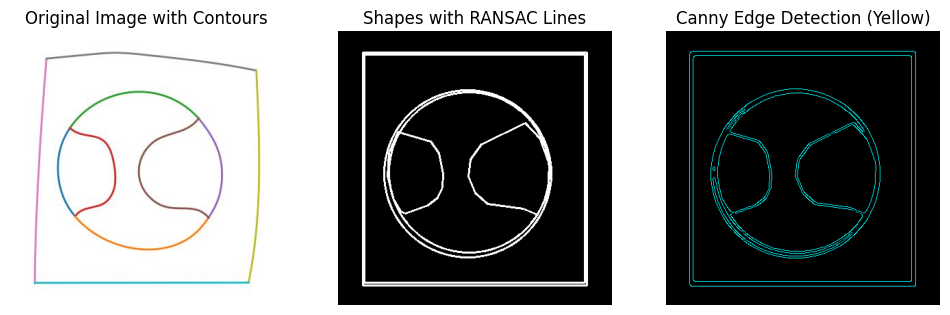

In [167]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def fit_line_ransac(points, threshold=0.5, max_iter=1000):
    best_line = None
    best_inliers = None
    num_points = len(points)

    for _ in range(max_iter):
        idx1, idx2 = np.random.choice(num_points, 2, replace=False)
        point1, point2 = points[idx1], points[idx2]

        if point2[0] == point1[0]:
            continue

        slope = (point2[1] - point1[1]) / (point2[0] - point1[0])
        intercept = point1[1] - slope * point1[0]
        distances = np.abs(slope * points[:, 0] - points[:, 1] + intercept) / np.sqrt(slope**2 + 1)
        inliers = points[distances < threshold]

        if best_inliers is None or len(inliers) > len(best_inliers):
            best_line = (slope, intercept)
            best_inliers = inliers

    return best_line

def draw_fitted_line(image, slope, intercept, color):
    height, width = image.shape[:2]
    y1 = int(intercept)
    y2 = int(slope * width + intercept)
    cv2.line(image, (0, y1), (width, y2), color, 2)

def draw_shape(image, shape_type, points, color):
    if shape_type == "line":
        pt1 = tuple(points[0][0])
        pt2 = tuple(points[1][0])
        cv2.line(image, pt1, pt2, color, 2)
    elif shape_type == "rectangle":
        x, y, w, h = cv2.boundingRect(points)
        top_left = (x, y)
        bottom_right = (x + w, y + h)
        cv2.rectangle(image, top_left, bottom_right, color, 2)
    elif shape_type == "circle":
        (x, y), radius = cv2.minEnclosingCircle(points)
        center = (int(x), int(y))
        radius = int(radius)
        cv2.circle(image, center, radius, color, 2)
    elif shape_type == "polygon":
        cv2.polylines(image, [points], isClosed=True, color=color, thickness=2)

def getShapeName(approx):
    if len(approx) == 2:
        shape_name = "line"
    elif len(approx) == 3:
        shape_name = "triangle"
    elif len(approx) == 4 or len(approx) == 5:
        shape_name = "rectangle"
    elif len(approx) > 12:
        shape_name = "circle"
    else:
        shape_name = "polygon"
    return shape_name

def process_contours(image, contours):
    shape_image = np.zeros_like(image)
    for cont in contours:
        epsilon = 0.0095 * cv2.arcLength(cont, True)
        approx = cv2.approxPolyDP(cont, epsilon, True)
        shape_name = getShapeName(approx)

        cv2.drawContours(image, [cont], 0, (0, 0, 255), 2)

        x, y, w, h = cv2.boundingRect(cont)
        cv2.putText(image, shape_name, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

        if shape_name == 'line':
            points = np.array(approx[:, 0], dtype=np.float32)
            line_params = fit_line_ransac(points)
            if line_params:
                slope, intercept = line_params
                draw_fitted_line(image, slope, intercept, (0, 255, 0))

        if shape_name == 'rectangle':
            draw_shape(shape_image, 'rectangle', approx, (255, 255, 255))
        elif shape_name == 'circle':
            draw_shape(shape_image, 'circle', approx, (255, 255, 255))
        elif shape_name == 'polygon':
            draw_shape(shape_image, 'polygon', approx, (255, 255, 255))

    return shape_image

# Load and preprocess image
img = cv2.imread('frag0.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find contours on the original image
edges = cv2.Canny(gray, 50, 150)
kernel = np.ones((4, 4), np.uint8)
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Create an image with shapes drawn
shape_image = np.zeros_like(img)
shape_image = process_contours(shape_image, contours)

# Convert the shape image to grayscale
shape_gray = cv2.cvtColor(shape_image, cv2.COLOR_BGR2GRAY)

# Apply Median Blur to the grayscale image
shape_median_blur = cv2.medianBlur(shape_gray, 5)

# Apply Canny Edge Detection to the median blurred image
edges_median_canny = cv2.Canny(shape_median_blur, 50, 150)

# Convert the Canny edges to a 3-channel image and color them yellow
edges_color = np.zeros_like(img)
edges_color[edges_median_canny > 0] = [255, 255, 0]  # Yellow color

# Plot all curves
plt.figure(figsize=(12, 9))

# Original Image with Contours
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image with Contours')
plt.axis('off')

# Image with shapes drawn and fitted lines
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(shape_image, cv2.COLOR_BGR2RGB))
plt.title('Shapes with RANSAC Lines')
plt.axis('off')

# Image with Canny edges (Median Blurred)
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(edges_color, cv2.COLOR_BGR2RGB))
plt.title('Canny Edge Detection (Yellow)')
plt.axis('off')

plt.show()


#Curve Commpletion